<center><h1>Store Sales - Time Series Forecasting (1)</h1></center>

<p>Welcome to my data science project, which is focused on store sales time series forecasting. The project was initiated by Kaggle, a popular platform for data science competitions and challenges. The objective of this project was to develop a model that can accurately predict the future sales of a store using historical sales data.</p>
<p>In this project, I have utilized my skills in data preprocessing, data visualization, and machine learning to analyze the dataset and develop a predictive model. The dataset was obtained from the Kaggle competition website (https://www.kaggle.com/competitions/store-sales-time-series-forecasting), which contained information on the sales of a store for a period of two years.</p>

### Data Preprocessing

This section contains how I preprocess the data provided. Preprocessing is an essential step to get the data ready for next operation procedures. If the data is preprocessed or clean, there's no null values inside, and the time series variable is continuous. Thus, in this Jupyter Notebook, I make the data ready for finding insights and fit in the machine learning models in the future.

First of all, I imported all essential modules for this project.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'matplotlib version: {mpl.__version__}')
print(f'seaborn version: {sns.__version__}')

numpy version: 1.24.2
pandas version: 1.5.3
matplotlib version: 3.7.0
seaborn version: 0.12.2


Then, I loaded the data from `stores.csv` and stored it in a DataFrame `df_store`.

In [2]:
file_path = 'datasets'
df_store = pd.read_csv(os.path.join(file_path, 'stores.csv'))

df_store.head(5)

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [3]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


`df_store` contains list of stores, their locations, types, and number of shops nearby. It's going to be useful to study all features of each store in this DataFrame.

However, I explored `oil.csv` first to find more data that could be useful for long-term analysis. In this file, I created a DataFrame named `df_oil` to store the data.

In [4]:
df_oil = pd.read_csv(os.path.join(file_path, 'oil.csv'))

df_oil.head(5)

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [5]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [6]:
print(f'Since: {df_oil.loc[0]["date"]}')
print(f'To: {df_oil.loc[len(df_oil.index) - 1]["date"]}')

Since: 2013-01-01
To: 2017-08-31


<p>`df_oil` contains oil prices stored since 1st of January, 2013, to 31st of August, 2017.</p>

<p>There are some null oil price values, so I decided to fill them by the average oil price of the month they lie in. Hence, I need to make sure whether there are no missing dates in `df_oil`, which were done by checking for 29th of February's rows in leap years first if there were any missing rows.</p>

In [7]:
# This function splits the "date" column into three columns, "day", "month", and "year".
def split_date(df):
  df['day'] = df['date'].apply(lambda date: int(date.split('-')[2]))
  df['month'] = df['date'].apply(lambda date: int(date.split('-')[1]))
  df['year'] = df['date'].apply(lambda date: int(date.split('-')[0]))
  return df

df_oil = split_date(df_oil) # list all years in "df_oil"

df_oil_years = df_oil['year'].unique()

# This function checks if the input year is a leap year.
def is_leap_year(year):
  if year % 4:
    return False
  else:
    if year % 100:
      return True
    else:
      if year % 400:
        return False
      else:
        return True

# Filter only leap years and display rows where the date is 29th of February
for year in df_oil_years:
  if is_leap_year(year):
    print(df_oil[(df_oil['day'] == 29) & (df_oil['month'] == 2) & (df_oil['year'] == year)])

           date  dcoilwtico  day  month  year
824  2016-02-29       32.74   29      2  2016


<p>It shows that 2016 is the only leap year in the range 2013-2017, and there exists a row of 29th of February, 2016. Therefore, I don't have to do anything.</p>

<p>Next, I checked for missing dates in common rules; contains all days, all months, and all years in the stored range.</p>

In [8]:
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # number of days in each month (February is set to have 28 days because February in leap years has been checked.)

# Check whether each date is missing from the DataFrame
for year in df_oil_years:

  # The final row is recorded in August, 2017, so the final month in 2017 is August.
  if year == 2017:
    final_month = 8
  else:
    final_month = 12

  for month in range(1, final_month + 1):
    for day in range(1, days_in_month[month - 1] + 1):
      # If the date is missing from the DataFrame, append a new row with the particular date with a null oil price value.
      if len(df_oil[(df_oil['day'] == day) & (df_oil['month'] == month) & (df_oil['year'] == year)].index) == 0:

        day_string = str(day)
        month_string = str(month)
        year_string = str(year)

        if day < 10:
          day_string = '0' + day_string
        if month < 10:
          month_string = '0' + month_string

        df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', np.nan, day, month, year]], columns=df_oil.columns, index=[0]), ignore_index=True)

df_oil = df_oil.sort_values(by=['year', 'month', 'day']).reset_index().drop('index', axis=1)

df_oil.info()

C:\Users\User\AppData\Local\Temp\ipykernel_22008\987130045.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', np.nan, day, month, year]], columns=df_oil.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22008\987130045.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', np.nan, day, month, year]], columns=df_oil.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22008\987130045.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month_st

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1704 non-null   object 
 1   dcoilwtico  1175 non-null   float64
 2   day         1704 non-null   int64  
 3   month       1704 non-null   int64  
 4   year        1704 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 66.7+ KB


<p>The date is now a continuous value since there is no missing dates anymore. Hence, I can finally fill some null values of oil prices into the DataFrame.</p>

In [9]:
for i in df_oil[df_oil['dcoilwtico'].isnull()].index:
  df_oil.at[i, 'dcoilwtico'] = df_oil[(df_oil['month'] == df_oil.loc[i]['month']) & (df_oil['year'] == df_oil.loc[i]['year']) & (df_oil['dcoilwtico'].notnull())]['dcoilwtico'].mean()

df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1704 non-null   object 
 1   dcoilwtico  1704 non-null   float64
 2   day         1704 non-null   int64  
 3   month       1704 non-null   int64  
 4   year        1704 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 66.7+ KB


<p>Now `df_oil` is complete and clean. For easy access, I saved the complete version of `df_oil` by exporting the DataFrame as another CSV file named `oil_clean.csv`.</p>

In [10]:
df_oil.to_csv(os.path.join(file_path, 'oil_clean.csv'), index=False)

df_oil = pd.read_csv(os.path.join(file_path, 'oil_clean.csv'))
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1704 non-null   object 
 1   dcoilwtico  1704 non-null   float64
 2   day         1704 non-null   int64  
 3   month       1704 non-null   int64  
 4   year        1704 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 66.7+ KB


<p>After that, I visited `holidays_events.csv` and stores its data into `df_holiday`.</p>

In [11]:
df_holiday = pd.read_csv(os.path.join(file_path, 'holidays_events.csv'))

df_holiday.head(5)

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [12]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


<p>This DataFrame contains dates of holidays, types of holidays, the place where the holidays take place, name of the holiday, and whether it's a transferred holiday.</p>
<p>The way of this DataFrame storing the data is not efficient to be used with other DataFrames since it doesn't include the direct data about which stores are on holidays. Instead, I created a new DataFrame that works like mentioned. The new DataFrame is named `df_holiday_new`. It contains the dates of holidays, whether the store is closed on that day (The store is closed when it's a holiday in its region and the holiday is not transferred or a work day.), type of the holiday, the store ID number that are affected on a particular date, and the holiday description.</p>

In [14]:
df_holiday_new_columns = ['date', 'store_closed', 'type', 'store_nbr', 'description']
df_holiday_new = pd.DataFrame(columns=df_holiday_new_columns)

for i in df_holiday.index:

    row = df_holiday.loc[i]

    # If it's a work day or a transferred holiday, the store is still opened.
    if row['type'] == 'Work Day' or (row['type'] == 'Holiday' and row['transferred'] == True):
        store_closed = False
    else:
        store_closed = True

    # If it's a national holiday, add all stores to "df_holiday_new".
    if row['locale'] == 'National':
        store_nbrs = range(1, 55)
    # If it's a regional holiday, add stores in the corresponding state to "df_holiday_new".
    elif row['locale'] == 'Regional':
        store_nbrs = df_store[df_store['state'] == row['locale_name']]['store_nbr'].values
    # If it's a local holiday, add stores in the corresponding city to "df_holiday_new".
    elif row['locale'] == 'Local':
        store_nbrs = df_store[df_store['city'] == row['locale_name']]['store_nbr'].values
    
    for store_nbr in store_nbrs:
        new_row = dict(zip(df_holiday_new_columns, [row['date'], store_closed, row['type'], store_nbr, row['description']]))
        df_holiday_new = df_holiday_new.append(new_row, ignore_index=True)
    
df_holiday_new.info()

C:\Users\User\AppData\Local\Temp\ipykernel_22008\1243381438.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holiday_new = df_holiday_new.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22008\1243381438.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holiday_new = df_holiday_new.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22008\1243381438.py:26: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_holiday_new = df_holiday_new.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22008\1243381438.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          9950 non-null   object
 1   store_closed  9950 non-null   object
 2   type          9950 non-null   object
 3   store_nbr     9950 non-null   object
 4   description   9950 non-null   object
dtypes: object(5)
memory usage: 388.8+ KB


C:\Users\User\AppData\Local\Temp\ipykernel_22008\1243381438.py:26: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_holiday_new = df_holiday_new.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22008\1243381438.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holiday_new = df_holiday_new.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22008\1243381438.py:26: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_holiday_new = df_holiday_new.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22008\1243381438.py:26: FutureWarning: The frame.append method is depr

`df_holiday_new` is ready to be used later on, so the DataFrame is exported as another CSV file named `holidays_events_clean.csv`.

In [15]:
df_holiday_new.to_csv(os.path.join(file_path, 'holidays_events_clean.csv'), index=False)

df_holiday = pd.read_csv(os.path.join(file_path, 'holidays_events_clean.csv'))
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          9950 non-null   object
 1   store_closed  9950 non-null   bool  
 2   type          9950 non-null   object
 3   store_nbr     9950 non-null   int64 
 4   description   9950 non-null   object
dtypes: bool(1), int64(1), object(3)
memory usage: 320.8+ KB


`transactions.csv` is the next file to survey. The DataFrame containing the data from the file is named `df_transactions`.

In [16]:
df_transactions = pd.read_csv(os.path.join(file_path, 'transactions.csv'))

df_transactions.head(5)

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [17]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


This DataFrame contains the date, store ID number, and the transaction price on each day. However, it's not ensured that the DataFrame contains all dates in the interval or all store ID's record is included on each date. Therefore, I created a new DataFrame that contains all dates according to `df_oil`. Each date contains all store IDs according to `df_store`. The new DataFrame is named `df_transactions_complete`.

In [18]:
df_transactions_complete = []
for date in df_oil['date'].unique():
    for store_nbr in df_store['store_nbr'].unique():
        df_transactions_complete.append([date, store_nbr])

len(df_transactions_complete)

92016

In [19]:
df_transactions_new = pd.DataFrame(np.array(df_transactions_complete), columns = ['date', 'store_nbr'])

df_transactions_new['store_nbr'] = df_transactions_new['store_nbr'].apply(lambda x: int(x))

df_transactions_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       92016 non-null  object
 1   store_nbr  92016 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [20]:
def get_transactions(data):
    result = df_transactions[(df_transactions['date'] == data[0]) & (df_transactions['store_nbr'] == data[1])]
    # If the data is not recorded in `df_transactions`, the transaction value is null.
    if len(result.index) == 0:
        return np.nan
    else:
        return result['transactions'].values[0]

df_transactions_new['transactions'] = df_transactions_new.apply(lambda data: get_transactions(data), axis=1)
df_transactions_new = df_transactions_new.sort_values(by=['date', 'store_nbr']).reset_index().drop('index', axis=1)

df_transactions_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          92016 non-null  object 
 1   store_nbr     92016 non-null  int64  
 2   transactions  83488 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


<p>According to the above cell, the `transactions` column still had null values, and I didn't have any clue how to fill the null data, so I decided to look for other data in case I found some values that can be proved to be correlated with the transaction value.</p>

<p>As a result, I looked at `train.csv` as the final data from which I could possibly get more insights. The data from the file is stored in a DataFrame named `df_train`.</p>

In [21]:
df_train = pd.read_csv(os.path.join(file_path, 'train.csv'))

df_train.head(5)

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

The `id` column is not necessary, so I dropped the column from the DataFrame.

In [22]:
df_train.drop('id', axis=1, inplace=True)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 114.5+ MB


<p>`df_train` contains dates, store ID numbers, types of products, sale prices, and the number of products which are on promotion.</p>

<p>To facilitate the DataFrame manipulation process, I decided to transform the value of the `family` column into numbers by creating a list of all distinct values named `family_types` and encode each value into the index it belongs to in the list.</p>

In [23]:
family_types = list(df_train['family'].unique())

len(family_types)

33

In [24]:
df_train['family'] = df_train['family'].apply(lambda family: family_types.index(family))

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       int64  
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 114.5+ MB


In [25]:
print(f'Since: {df_train.loc[0]["date"]}')
print(f'To: {df_train.loc[len(df_train.index) - 1]["date"]}')

Since: 2013-01-01
To: 2017-08-15


Like how it was in `df_transactions`, it's not ensured that the DataFrame contains all dates in the interval, all store ID records are included on each date, and all types of product records are included in each store. Therefore, I created a new DataFrame that contains all dates as noted in `df_train` itself (which is 15th of August, 2017). Each date contains all store IDs according to `df_store`. Each store ID contains all `family` values. The new DataFrame is named `df_train_new`.

In [26]:
df_train_complete = []
for date in df_oil['date'].loc[:df_oil[df_oil['date'] == '2017-08-15'].index[0]].values:
    for store_nbr in df_store['store_nbr'].unique():
        for family in range(0, 33):
            df_train_complete.append([date, store_nbr, family])

df_train_new = pd.DataFrame(np.array(df_train_complete), columns=['date', 'store_nbr', 'family'])

df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   date       object
 1   store_nbr  object
 2   family     object
dtypes: object(3)
memory usage: 68.8+ MB


In [27]:
df_train_new['store_nbr'] = df_train_new['store_nbr'].apply(lambda x: int(x))
df_train_new['family'] = df_train_new['family'].apply(lambda x: int(x))

df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   date       object
 1   store_nbr  int64 
 2   family     int64 
dtypes: int64(2), object(1)
memory usage: 68.8+ MB


I left-merged `df_train_new` with the original `df_train` in order to find some missing rows in `df_train`, for the new DataFrame after merging contains one more column named `_merge` that identifies whether the particular row exists in both DataFrame or not. Consequently, if the `_merge` value of a row is not `both`, the row surely is missing in `df_train`. I, then, gathered the missing rows and stored them in a DataFrame named `df_train_missing` to be used later.

In [28]:
df_train_new = df_train_new.merge(df_train[['date', 'store_nbr', 'family']].drop_duplicates(), how='left', indicator=True)

df_train_missing = df_train_new[df_train_new['_merge'] != 'both']
df_train_missing['sales'] = np.nan
df_train_missing['onpromotion'] = np.nan
df_train_missing.drop('_merge', axis=1, inplace=True)

df_train_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7128 entries, 637956 to 2592809
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7128 non-null   object 
 1   store_nbr    7128 non-null   int64  
 2   family       7128 non-null   int64  
 3   sales        0 non-null      float64
 4   onpromotion  0 non-null      float64
dtypes: float64(2), int64(2), object(1)
memory usage: 334.1+ KB


C:\Users\User\AppData\Local\Temp\ipykernel_22008\3481562097.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_missing['sales'] = np.nan
C:\Users\User\AppData\Local\Temp\ipykernel_22008\3481562097.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_missing['onpromotion'] = np.nan
C:\Users\User\AppData\Local\Temp\ipykernel_22008\3481562097.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

Subsequently, I concatenate the original `df_train` and `df_train_missing` to finally get `df_train_new` complete in the three columns; `date`, `store_nbr`, `family`.

In [29]:
df_train_new = pd.concat([df_train, df_train_missing])
df_train_new = df_train_new.sort_values(by=['date', 'store_nbr', 'family']).reset_index().drop('index', axis=1)

df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       int64  
 3   sales        float64
 4   onpromotion  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 114.7+ MB


<p>There are 2 columns left waiting to be filled null values; `sales` and `onpromotion`, so I took a look at those rows that have null `sales` values first.</p>

In [30]:
df_train_new[df_train_new['sales'].isna()]['date'].unique()

array(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'],
      dtype=object)

In [31]:
len(df_holiday[(df_holiday['date'] == '2013-12-25') & (df_holiday['store_closed'] == True)].index) == len(df_store.index)

True

In [32]:
df_train_new[df_train_new['onpromotion'].isna()]['date'].unique()

array(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'],
      dtype=object)

I found that those dates were 25th of December of every year, which is a Christmas day. Moreover, it's added in `df_holiday` that all stores are closed on Christmas days. Hence, `sales` values of every Christmas must be 0. Besides, `onpromotion` values are null on every Christmas day as well, so I can fill all null values in `df_train_new` to 0.

In [33]:
df_train_new.fillna(0, inplace=True)

df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       int64  
 3   sales        float64
 4   onpromotion  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 114.7+ MB


Almost finally, I decoded `family` values into the original strings as it could be beneficial when finding insights soon.

In [34]:
df_train_new['family'] = df_train_new['family'].apply(lambda x: family_types[x])

df_train_new['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

Like what I had done in previous DataFrames, I export `df_train_new` to a new CSV file named `train_clean.csv`.

In [35]:
df_train_new.to_csv(os.path.join(file_path, 'train_clean.csv'), index=False)

df_train = pd.read_csv(os.path.join(file_path, 'train_clean.csv'))
df_train.head(5)

date  store_nbr      family  sales  onpromotion
0  2013-01-01          1  AUTOMOTIVE    0.0          0.0
1  2013-01-01          1   BABY CARE    0.0          0.0
2  2013-01-01          1      BEAUTY    0.0          0.0
3  2013-01-01          1   BEVERAGES    0.0          0.0
4  2013-01-01          1       BOOKS    0.0          0.0

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 114.7+ MB


Yet, `df_transactions` still contains null values. Based on my intuition, there could be a correlation between the sum of `sales` values and `transaction` value in each store on each day since the amount of money in transaction typically depends on the money the store has, and the money in the store comes from sales. Therefore, I planned to visualise the relationship between both variables using a scatter plot and see the correlation coefficient to make a decision later.

In [37]:
df_train['sales'] = df_train['sales'].astype('float32') # for performance improve

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float32
 4   onpromotion  float64
dtypes: float32(1), float64(1), int64(1), object(2)
memory usage: 103.3+ MB


I created a DataFrame storing total sales and transactions in each store on each day named `df_sales_transactions`.

In [38]:
df_sales_transactions = pd.read_csv(os.path.join(file_path, 'transactions.csv'))
avg_sales = df_train.groupby(['date', 'store_nbr'])['sales'].sum()
df_sales_transactions['total_sales'] = df_sales_transactions[['date', 'store_nbr']].apply(lambda x: avg_sales[x[0]][x[1]], axis=1)

df_sales_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          83488 non-null  object 
 1   store_nbr     83488 non-null  int64  
 2   transactions  83488 non-null  int64  
 3   total_sales   83488 non-null  float32
dtypes: float32(1), int64(2), object(1)
memory usage: 2.2+ MB


<Axes: xlabel='total_sales', ylabel='transactions'>

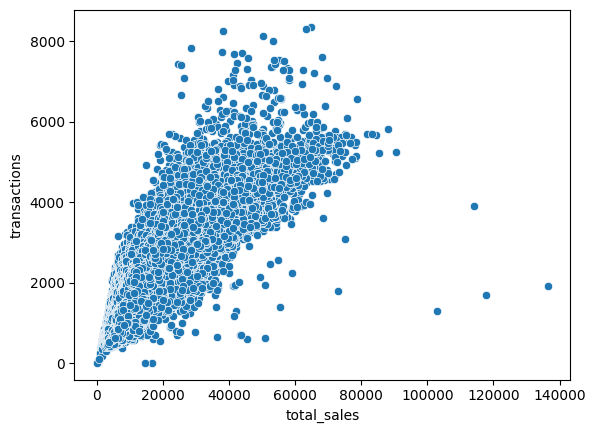

In [39]:
sns.scatterplot(data=df_sales_transactions, x="total_sales", y="transactions")

In [40]:
df_sales_transactions[['total_sales', 'transactions']].corr()

total_sales  transactions
total_sales      1.000000      0.837384
transactions     0.837384      1.000000

According to the scatter plot and having approximately 0.84 as the correlation coefficient value, there's a strong correlation between the total sales value and the transaction value. Consequently, I used a linear regression machine learning model to predict what the missing transaction values are.

In [41]:
X = df_sales_transactions['total_sales'].values
X = X.reshape(len(X), 1)
y = df_sales_transactions['transactions'].values

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

print(len(X_train), len(y_train), len(X_val), len(y_val))

55936 55936 27552 27552


We only had sales values until 15th of August, 2017, because it's the last date when the sales value in `df_train` is noted. Hence, I could fill null transaction values only in the dates in `df_train`'s interval, so I created a new DateFrame named `df_transactions_train` to store rows of which the date is in `df_train`'s interval.

In [42]:
df_transactions_train = df_transactions_new.loc[:df_transactions_new[df_transactions_new['date'] == '2017-08-15'].index[-1]]
df_transactions_null = df_transactions_train[['date', 'store_nbr']].merge(df_sales_transactions[['date', 'store_nbr']].drop_duplicates(), how='left', indicator=True)
df_transactions_missing = df_transactions_null[df_transactions_null['_merge'] != 'both']
df_transactions_missing.drop('_merge', axis=1, inplace=True)
X_test = np.array([avg_sales[row[0]][row[1]] for row in df_transactions_missing.values])
X_test = X_test.reshape(len(X_test), 1)

len(X_test)

C:\Users\User\AppData\Local\Temp\ipykernel_22008\3486063261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transactions_missing.drop('_merge', axis=1, inplace=True)


7664

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

reg = LinearRegression().fit(X_train, y_train)
y_val_pred = reg.predict(X_val)

print(f'r2: {r2_score(y_val, y_val_pred)}')
mse = mean_squared_error(y_val, y_val_pred)
print(f'MSE: {mse}')
print(f'RMSE: {np.sqrt(mse)}')
print(f'MAE: {mean_absolute_error(y_val, y_val_pred)}')

r2: 0.6982924529593408
MSE: 277448.20781102905
RMSE: 526.7335263784042
MAE: 391.5944382560101


The upper cell shows the affordable performance of the model I used, so I used the same model to predict the missing transaction values.

In [44]:
y_test = list(reg.predict(X_test))

len(y_test)

7664

After that, I filled null transaction values by the predicted values.

In [45]:
df_transactions_train['transactions'] = df_transactions_train['transactions'].apply(lambda y: y_test.pop(0) if np.isnan(y) else y)

df_transactions_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91152 entries, 0 to 91151
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          91152 non-null  object 
 1   store_nbr     91152 non-null  int64  
 2   transactions  91152 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


C:\Users\User\AppData\Local\Temp\ipykernel_22008\1685665107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transactions_train['transactions'] = df_transactions_train['transactions'].apply(lambda y: y_test.pop(0) if np.isnan(y) else y)


Finally, I got the complete `df_transactions_train`, so I saved it in a CSV file named `transactions_clean.csv`.

In [46]:
df_transactions_train.to_csv(os.path.join(file_path, 'transactions_clean.csv'), index=False)

df_transactions = pd.read_csv(os.path.join(file_path, 'transactions_clean.csv'))
df_transactions.head()

date  store_nbr  transactions
0  2013-01-01          1    626.164917
1  2013-01-01          2    626.164917
2  2013-01-01          3    626.164917
3  2013-01-01          4    626.164917
4  2013-01-01          5    626.164917